# Aim 1 Analysis: Days 7 to Day 13 

In this notebook, we will be completing our analysis of Days 7 - Day 13 of the CD34+ Cells in LEM. 

Aim 1 is defined as: `Characterizing T-Lineage Restriction of Lymphoid Progenitors through Phenotypic and Transcriptomic Analysis `

The objectives of this Aim are: 
1.

2.

3.

4.

5.


## Pre-Processing Workflow

Here, we begin by loading in necessary libraries, cleaning our data up to remove outliers from the UMAP space, and visualizing the general UMAP results. 

Let's begin with loading in the necessary libraries. The comments indicate what each library allows us to do in this workflow. 

In [1]:
# Loading Libraries

library(BiocSingular) # We need this to use the BioConductor libraries that work on the Single Cell data. #nolint
library(SingleCellExperiment) # We need this to use the SingleCellExperiment data structure. nolint
library(ggplot2) # we need this to make ggplot visualizations #nolint
library(tidyr) # we need this to manipulate data #nolint
library(dplyr) # we need this to manipulate data #nolint

library(scuttle)
library(scran)
library(scater)
library(GO.db)
library(limma)
library(org.Hs.eg.db)
# library(scDblFinder)
# library(DropletUtils)
# library(DropletTestFiles)
library(uwot)
# library(rtracklayer)
# library(PCAtools)
# library(celldex)
# library(SingleR)
# library(batchelor)
library(bluster)


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

Based on the process outlined in `d0_Analysis.ipynb`, I've created SingleCell Objects containing eexperimental data from the d7-d13 timepoints. 

In [2]:
load("data/phenotype_with_ID.RData")
load("data/merge2.RData")


We have now loaded pre-processed merge2 data, and the associated phenotypes. Next, I will create an index linking cells to their phenotype. This will allow me to connect them to their flow_cytometry populations. 

In [3]:
pheno.d7 <- rep("CD34+CD45RA-CLEC12A-", 3039)
names(pheno.d7) <- colnames(merge2)[1:3039]

pheno.merge2 <- c(pheno.d7, pheno.d10, pheno.d13)


The next step would be to complete PCA on our top genes. This has already be done, we simply need to access it using the `reducedDimNames` command. 

In [4]:
# PCA has already been done on the top genes
reducedDimNames(merge2)


[1] "PCA.cc"    "UMAP.cc"   "PCA.5k"    "PCA.nocc"  "UMAP.nocc" "TSNE.nocc"
[7] "TSNE.5k"   "PCA"       "TSNE"

Ok nice - next we add phenotype metadata

In [5]:
# Add phenotypes as a column in colData
colData(merge2)$Phenotype <- pheno.merge2


Lets create a seperate dataframe containing just the UMAP representation of the genespace, along with all relevant genes. Lets also manually link the cell's phenotype to this dataframe. 

In [6]:
umap_df <- reducedDim(merge2, "UMAP.cc") %>% as.data.frame()
umapPheno_df <- umap_df %>% mutate(Phenotype = pheno.merge2)

head(umapPheno_df)


UMAP1       UMAP2      Phenotype           
cell1Day_7 -5.79068856  2.3167820 CD34+CD45RA-CLEC12A-
cell2Day_7 -4.55423741 -1.4934861 CD34+CD45RA-CLEC12A-
cell3Day_7 -2.27152901 -0.1340941 CD34+CD45RA-CLEC12A-
cell4Day_7  0.02322112 -3.4786522 CD34+CD45RA-CLEC12A-
cell5Day_7 -6.10011964  0.9243375 CD34+CD45RA-CLEC12A-
cell6Day_7 -4.40012555  2.7331555 CD34+CD45RA-CLEC12A-

As we can see, there's too many phenotypes present here. Lets break the data into our 3 populations of interest, and ignore everything else as an `Other` category, to better understand our question. 

In [7]:
# Establishing Population Groups

# Define phenotype groups
phenotype_groups <- list(
  Raneg_Cneg = c("CD34+CD45RA-CLEC12A-", "CD34-CD45RA-CLEC12A-"), # Ra-C-
  Rapos_Cneg = c("CD34+CD45RA+CLEC12A-", "CD34-CD45RA+CLEC12A-"), # Ra+C-
  Cpos = c("CD34-CD45RA-CLEC12A+", "CD34+CD45RA-CLEC12A+", "CD34+CD45RA+CLEC12A+", "CD34-CD45RA+CLEC12A+"), # C+ # nolint
  Other = c("CD10+", "CD14CD15+") # Pro -B #Pro-NM #FW Gating from a flow cytometer #nolint
)

# Assign group labels to phenotypes
group_labels <- sapply(pheno.merge2, function(phenotype) {
  group <- names(phenotype_groups)[sapply(phenotype_groups, function(g) phenotype %in% g)] # nolint
  if (length(group) > 0) group else "Other"
})

# Add group labels to colData of the SCE object
colData(merge2)$Group <- group_labels

# Add these group labels to the exsiting UMPA dataframe
umapPheno_df$Group <- colData(merge2)$Group

head(umapPheno_df)


UMAP1       UMAP2      Phenotype            Group     
cell1Day_7 -5.79068856  2.3167820 CD34+CD45RA-CLEC12A- Raneg_Cneg
cell2Day_7 -4.55423741 -1.4934861 CD34+CD45RA-CLEC12A- Raneg_Cneg
cell3Day_7 -2.27152901 -0.1340941 CD34+CD45RA-CLEC12A- Raneg_Cneg
cell4Day_7  0.02322112 -3.4786522 CD34+CD45RA-CLEC12A- Raneg_Cneg
cell5Day_7 -6.10011964  0.9243375 CD34+CD45RA-CLEC12A- Raneg_Cneg
cell6Day_7 -4.40012555  2.7331555 CD34+CD45RA-CLEC12A- Raneg_Cneg

Nice! We can now begin visualizing the UMAP using the  `ggplot` package. 

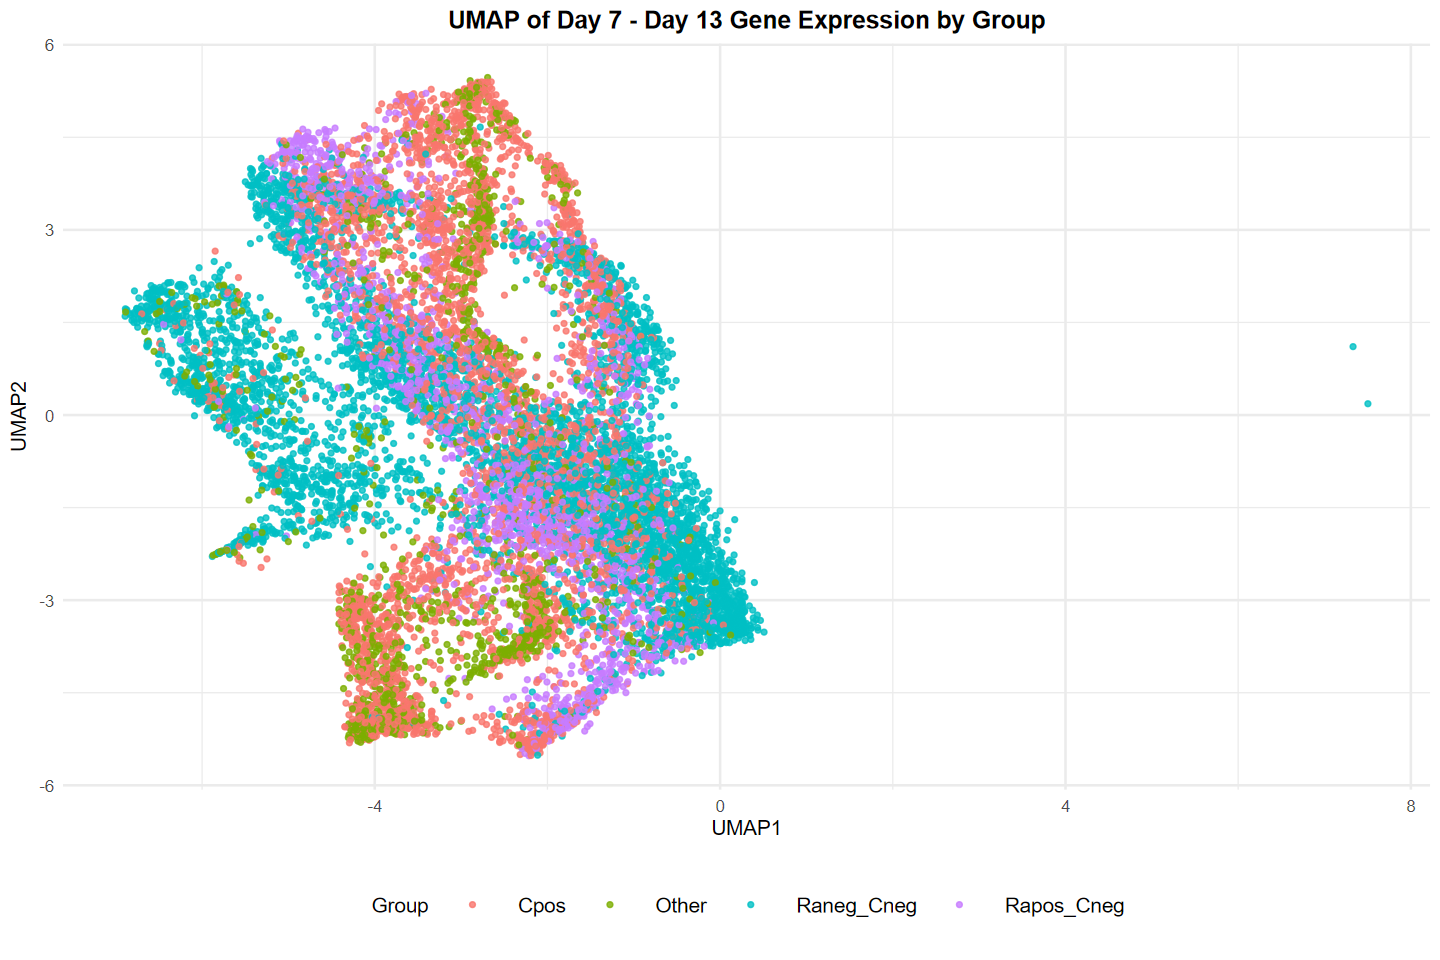

In [8]:
options(repr.plot.width = 12, repr.plot.height = 8)

gg_umap <- ggplot(umapPheno_df, aes(x = UMAP1, y = UMAP2, color = Group)) +
  geom_point(alpha = 0.8, size = 1) +
  labs(
    title = "UMAP of Day 7 - Day 13 Gene Expression by Group",
    x = "UMAP1",
    y = "UMAP2",
    color = "Group"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    legend.position = "bottom",
    legend.text = element_text(size = 12), # Increase legend text size
    legend.key.size = unit(1.5, "cm") # Increase legend color box size
  )

# Print the UMAP plot
print(gg_umap)


It appears that we have to outliers, with a value exceedin `UMAP1 = 4` on the x-axis. Lets get rid of these, and then continue with our analysis. 

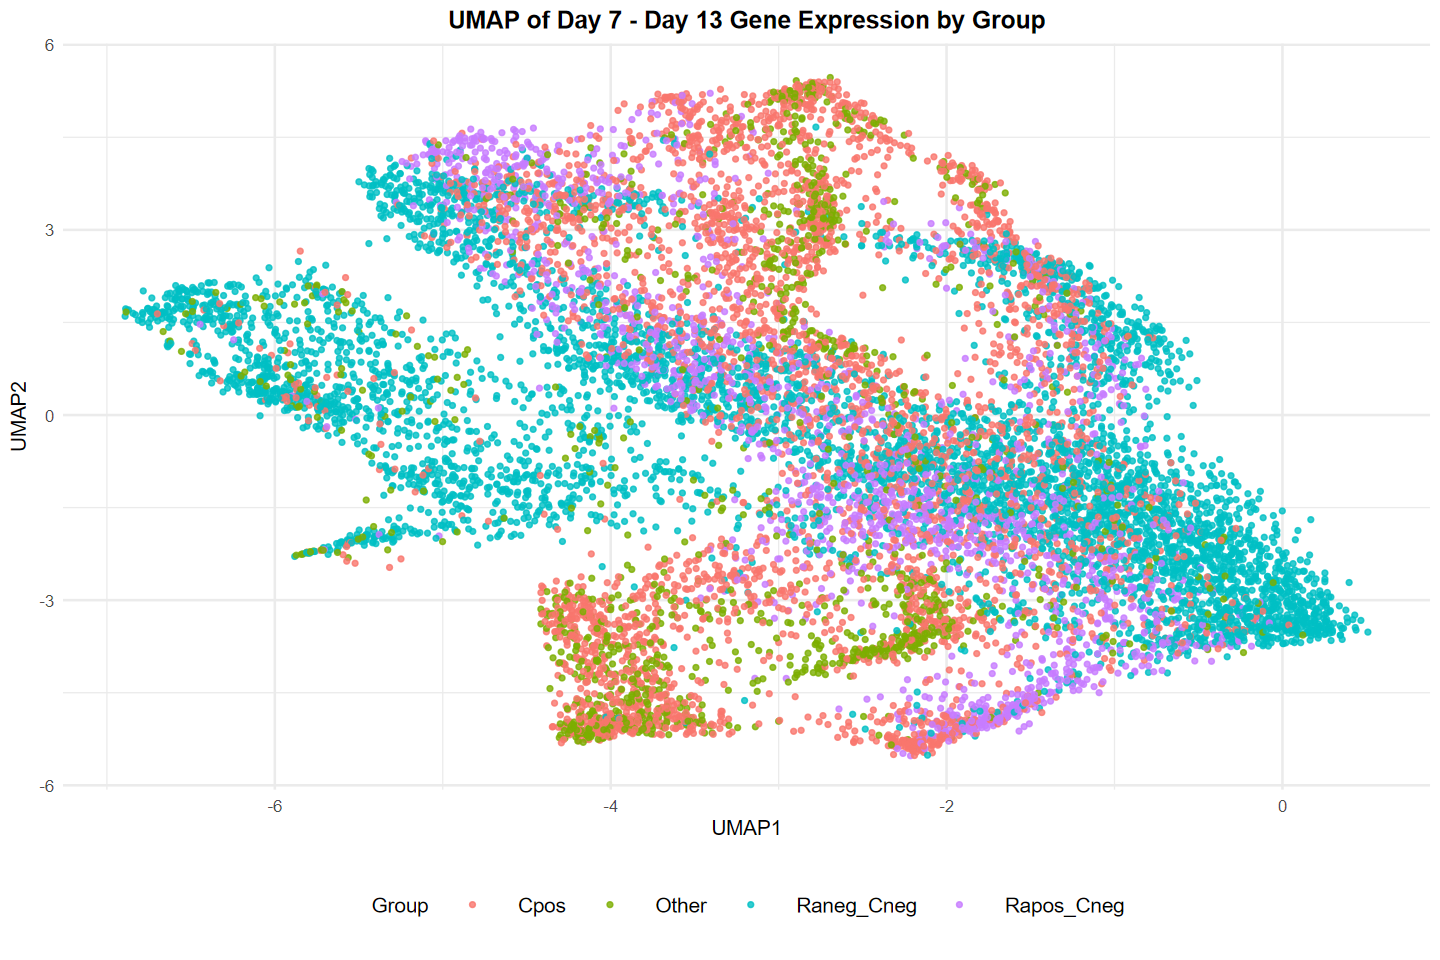

In [9]:
umapPheno_clean <- umapPheno_df %>% filter(UMAP1 < 4)

gg_umap <- ggplot(umapPheno_clean, aes(x = UMAP1, y = UMAP2, color = Group)) +
  geom_point(alpha = 0.8, size = 1) +
  labs(
    title = "UMAP of Day 7 - Day 13 Gene Expression by Group",
    x = "UMAP1",
    y = "UMAP2",
    color = "Group"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    legend.position = "bottom",
    legend.text = element_text(size = 12), # Increase legend text size
    legend.key.size = unit(1.5, "cm") # Increase legend color box size
  )

# Print the UMAP plot
print(gg_umap)


## Analysis Workflow 

### Question 1: How are the 3 Populations of Interest Related in the the Genespace? 

In this section, we will be looking at how the three populations are similiar, and how they are different, at a genespace level. The goal is to especially establish the changes in cell fate differences in the 3 populations. 

#### Visualizing the 3 Populations of Interest in the Genespace 

Lets begin by visualizing the 3 Populations in the genespace, and looking for qualitative differences and similarities. 

Nice! Lets begin by creating a faceted visualization, showing the distribution of the 3 populations overlaid in the same UMAP. 

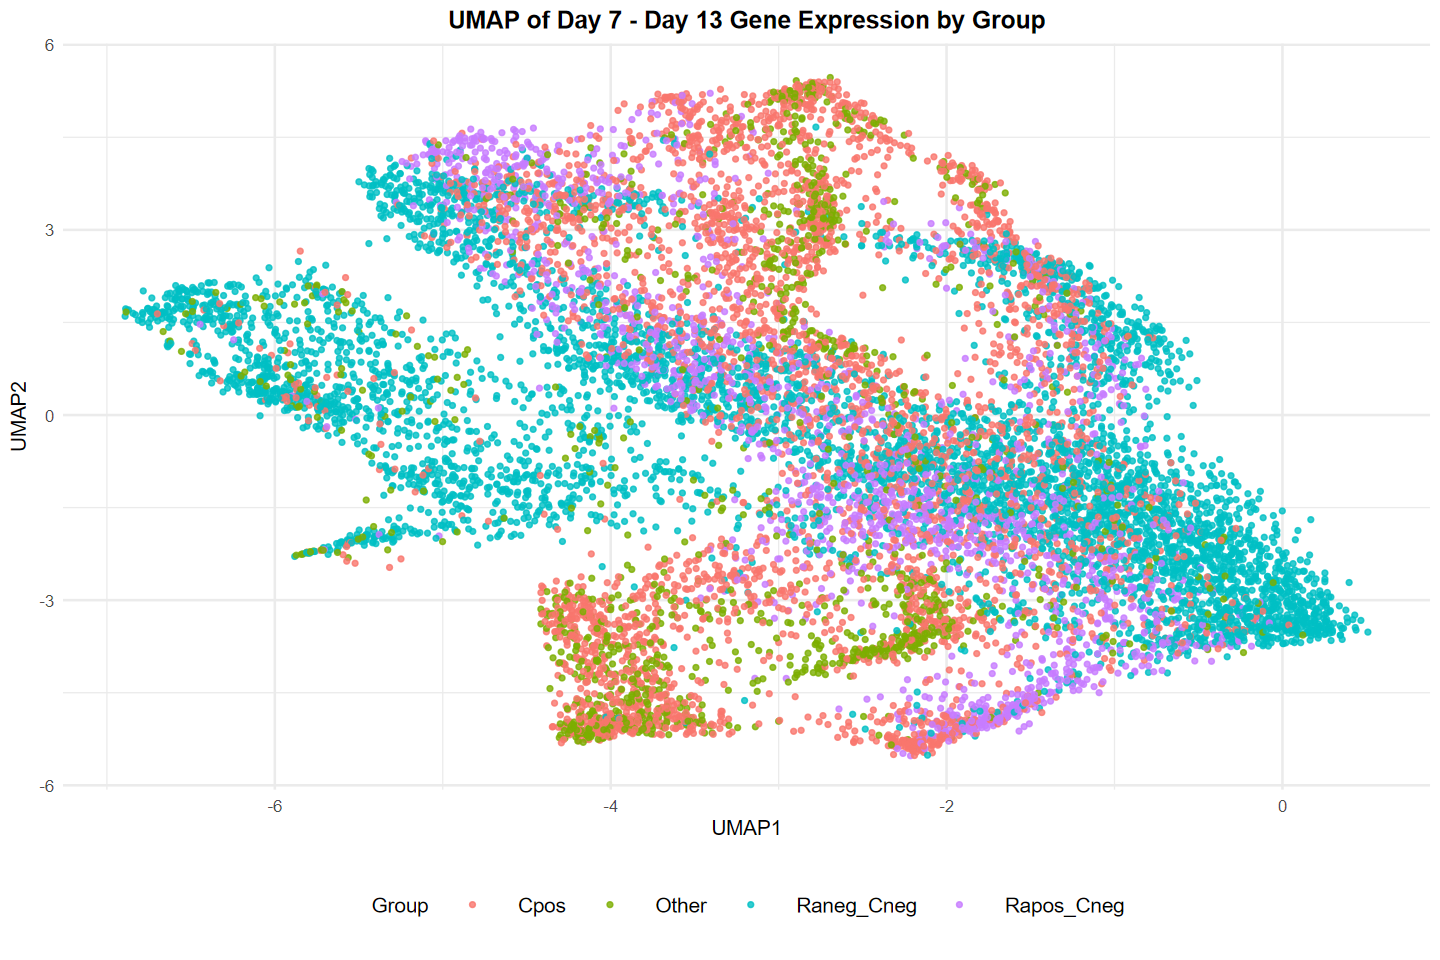

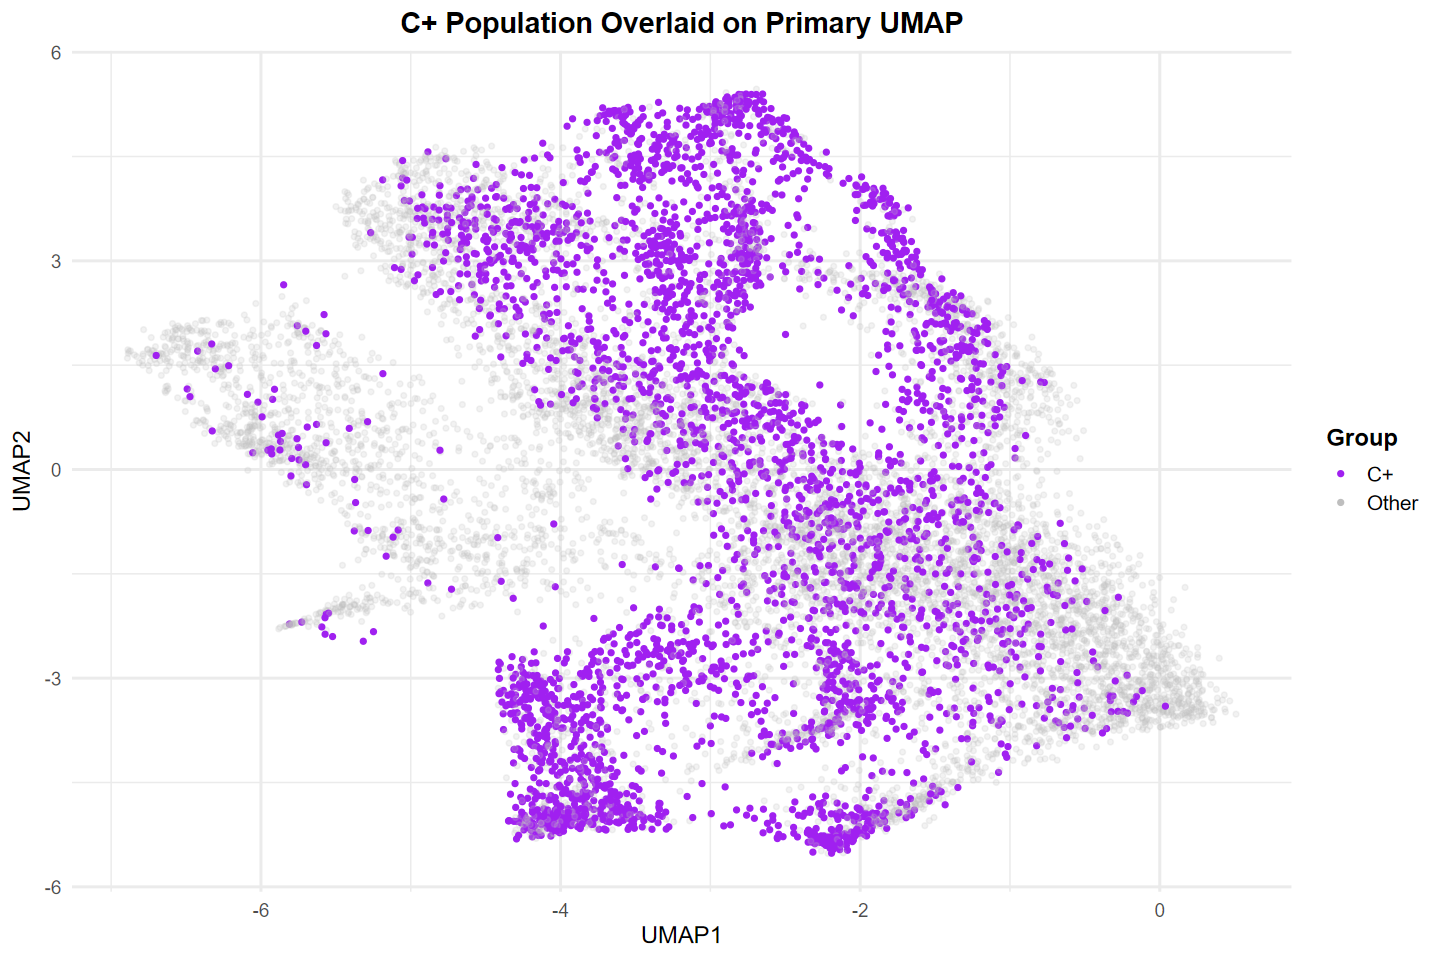

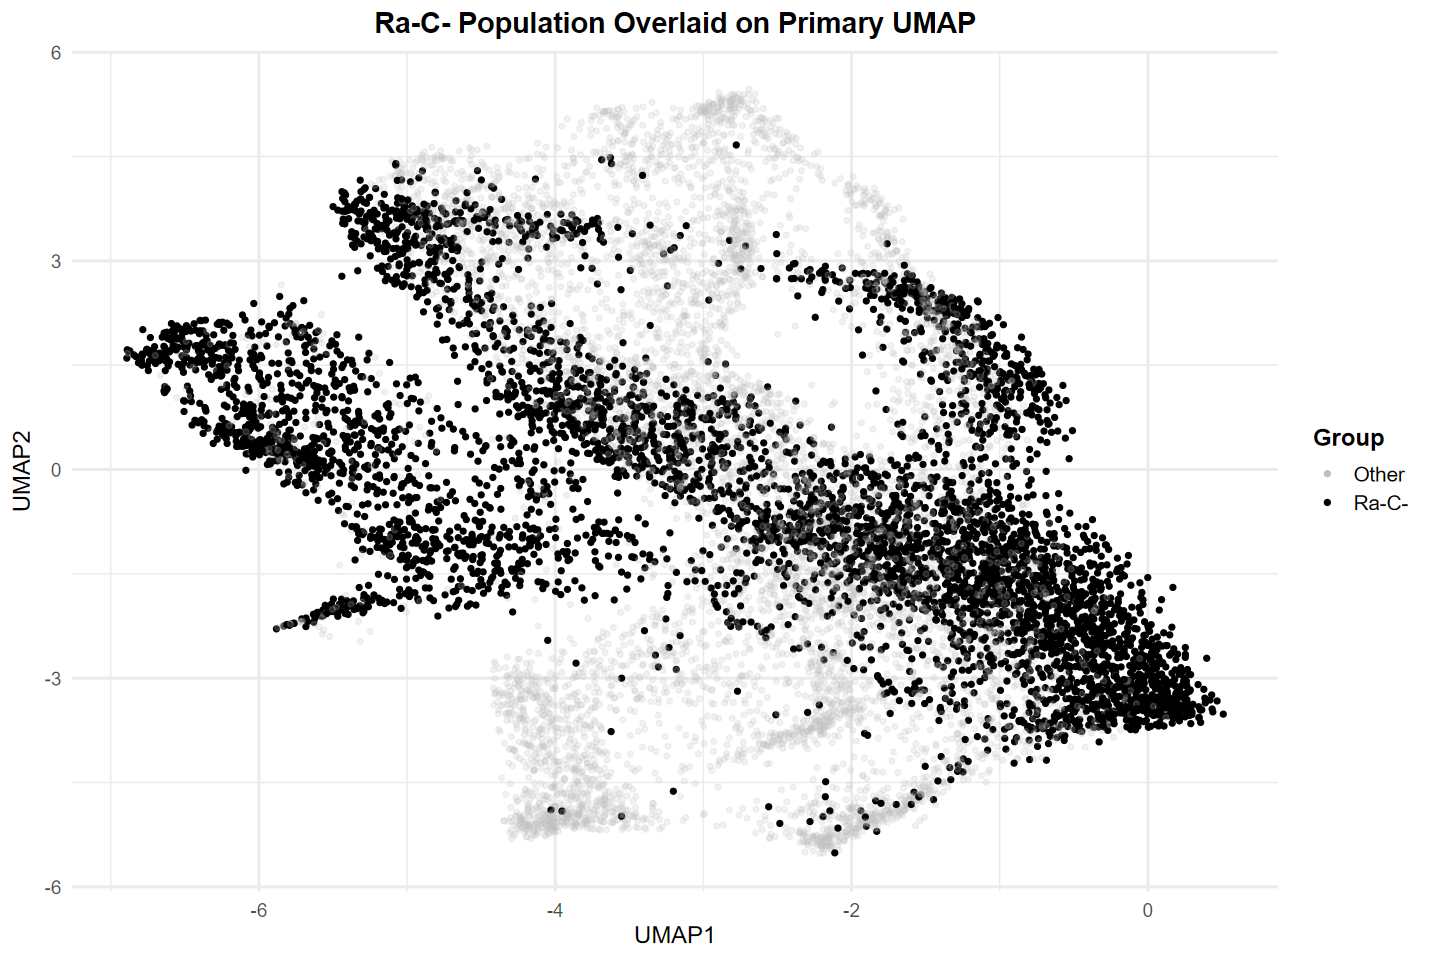

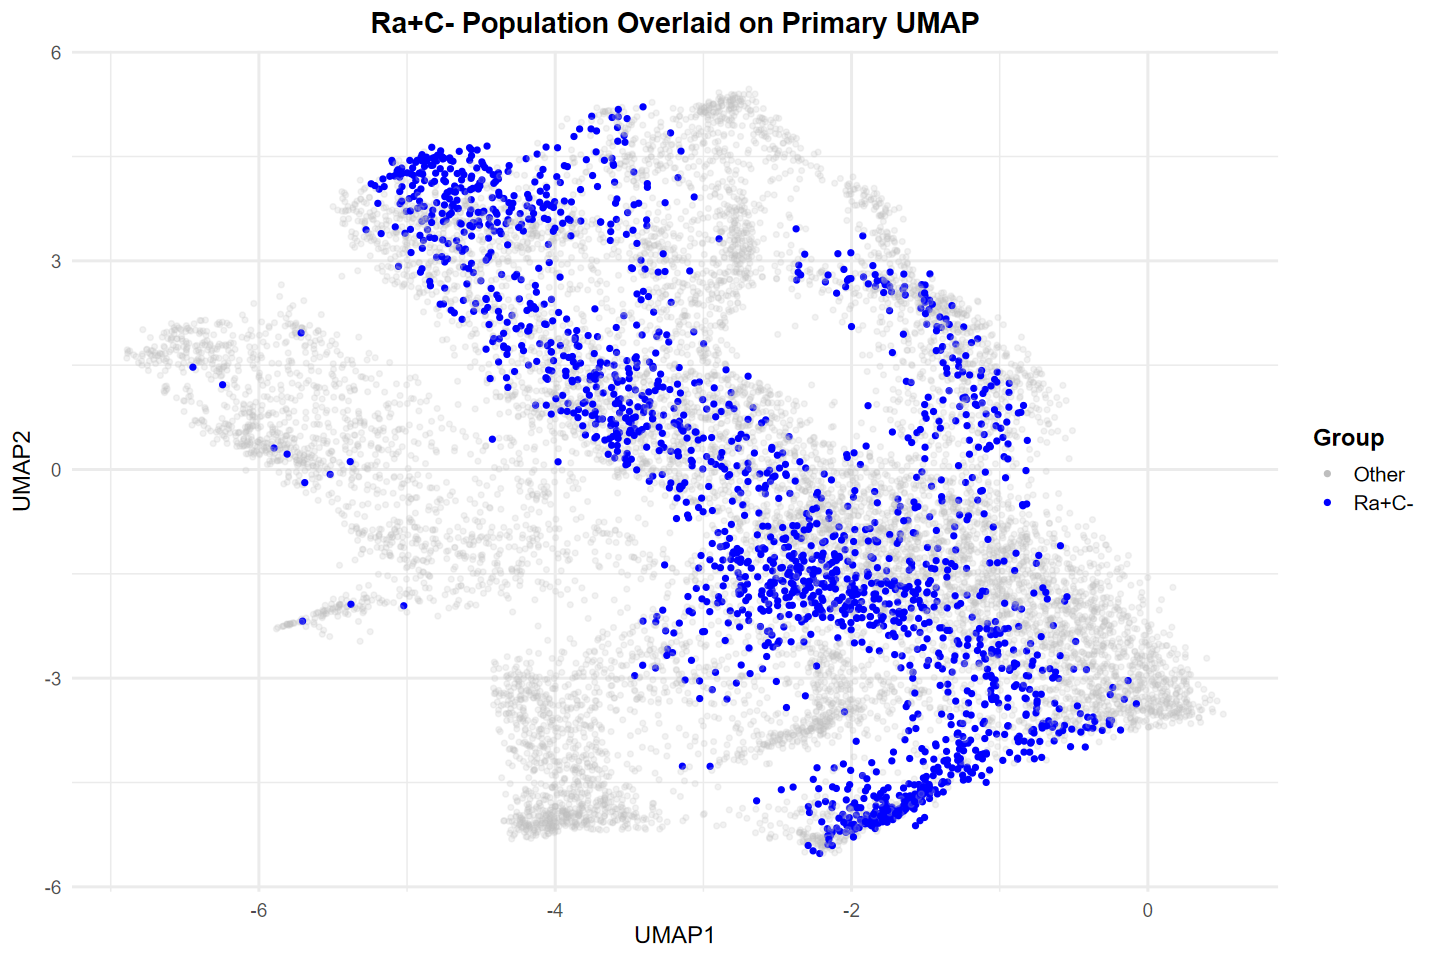

In [10]:
gg1 <- gg_umap

gg_Cpos <- ggplot(umapPheno_clean, aes(x = UMAP1, y = UMAP2)) +
  geom_point(aes(color = ifelse(Group == "Cpos", "C+", "Other")),
    alpha = ifelse(umapPheno_clean$Group == "Cpos", 1, 0.2), size = 1
  ) +
  scale_color_manual(
    values = c("C+" = "purple", "Other" = "gray"),
    name = "Group"
  ) +
  labs(
    title = "C+ Population Overlaid on Primary UMAP",
    x = "UMAP1",
    y = "UMAP2"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    legend.position = "right",
    legend.text = element_text(size = 12),
    legend.title = element_text(size = 14, face = "bold")
  )

gg_RanegCneg <- ggplot(umapPheno_clean, aes(x = UMAP1, y = UMAP2)) +
  geom_point(aes(color = ifelse(Group == "Raneg_Cneg", "Ra-C-", "Other")),
    alpha = ifelse(umapPheno_clean$Group == "Raneg_Cneg", 1, 0.2), size = 1
  ) +
  scale_color_manual(
    values = c("Ra-C-" = "black", "Other" = "gray"),
    name = "Group"
  ) +
  labs(
    title = "Ra-C- Population Overlaid on Primary UMAP",
    x = "UMAP1",
    y = "UMAP2"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    legend.position = "right",
    legend.text = element_text(size = 12),
    legend.title = element_text(size = 14, face = "bold")
  )

gg_RaposCneg <- ggplot(umapPheno_clean, aes(x = UMAP1, y = UMAP2)) +
  geom_point(aes(color = ifelse(Group == "Rapos_Cneg", "Ra+C-", "Other")),
    alpha = ifelse(umapPheno_clean$Group == "Rapos_Cneg", 1, 0.2), size = 1
  ) +
  scale_color_manual(
    values = c("Ra+C-" = "blue", "Other" = "gray"),
    name = "Group"
  ) +
  labs(
    title = "Ra+C- Population Overlaid on Primary UMAP",
    x = "UMAP1",
    y = "UMAP2"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    legend.position = "right",
    legend.text = element_text(size = 12),
    legend.title = element_text(size = 14, face = "bold")
  )



# Print the UMAP plot
print(gg1)
print(gg_Cpos)
print(gg_RanegCneg)
print(gg_RaposCneg)


Very interesting, what are some take-aways we can see from this distribution. Perhaps we can manually subset groups and complete DGE on them, to look for more pronounced differences between groups: 

1. All groups have some homogeneity along the diagonal, which is their primary region of overlap. 

2. At the bottom left, the island is primarily C+ cells. That area is dominated by the C+ cells, and nothing else. Hence, it appears to be a near homogenous C+ population that exists there, within this dataset. Similiarly, the peak at the top of the plot is also dominated by C+ cells, and could be another subset to look at when completing DGE. 

3. The larger island, on a diagonal from -4 to -7, seems to be primarily occuped by the Ra-C- population. Additionally, the bottom right peak also seems to be enriched for this population. 

4. The small long island at the bottom is very enriched for Ra+C- cells, but the lower half has some overlap with C+ population. Additionally, there is a small enrichment in the top left, which is unique to the population, but it is limited. 

#### Comparing DGE Between the 3 Populations 

Okay - lets look at the differential gene expression among the 3 different populations. We will begin by completing `Differential Gene Expression` (DGE) analysis. Lets begin by making sure we have a `SingleCellObject` with the normalized expression data, and the necessary population grouping. 

Warning message in estimateDisp.default(y = y$counts, design = design, group = group, :
"No residual df: setting dispersion to NA"


ERROR: Error in glmFit.default(y, design = design, dispersion = dispersion, offset = offset, : NA dispersions not allowed


In [15]:
table(dge$samples$group)



      Cpos      Other Raneg_Cneg Rapos_Cneg 
         1          1          1          1 

In [101]:
rownames(assay(merge2, "logcounts"))


[1] "MIR1302-2HG"       "FAM138A"           "OR4F5"            
    [4] "AL627309.1"        "AL627309.3"        "AL627309.2"       
    [7] "AL627309.5"        "AL627309.4"        "AP006222.2"       
   [10] "AL732372.1"        "OR4F29"            "AC114498.1"       
   [13] "OR4F16"            "AL669831.2"        "LINC01409"        
   [16] "FAM87B"            "LINC01128"         "LINC00115"        
   [19] "FAM41C"            "AL645608.6"        "AL645608.2"       
   [22] "AL645608.4"        "LINC02593"         "SAMD11"           
   [25] "NOC2L"             "KLHL17"            "PLEKHN1"          
   [28] "PERM1"             "AL645608.7"        "HES4"             
   [31] "ISG15"             "AL645608.1"        "AGRN"             
   [34] "AL645608.5"        "AL645608.8"        "RNF223"           
   [37] "C1orf159"          "AL390719.3"        "LINC01342"        
   [40] "AL390719.2"        "TTLL10-AS1"        "TTLL10"           
   [43] "TNFRSF18"          "TNFRSF4"           "SDF4"             
   [46] "B3GALT6"           "C1QTNF12"          "AL162741.1"       
   [49] "UBE2J2"            "LINC01786"         "SCNN1D"           
   [52] "ACAP3"             "PUSL1"             "INTS11"           
   [55] "AL139287.1"        "CPTP"              "TAS1R3"           
   [58] "DVL1"              "MXRA8"             "AURKAIP1"         
   [61] "CCNL2"             "MRPL20-AS1"        "MRPL20"           
   [64] "AL391244.2"        "ANKRD65"           "AL391244.1"       
   [67] "TMEM88B"           "LINC01770"         "VWA1"             
   [70] "ATAD3C"            "ATAD3B"            "ATAD3A"           
   [73] "TMEM240"           "SSU72"             "AL645728.1"       
   [76] "FNDC10"            "AL691432.4"        "AL691432.2"       
   [79] "MIB2"              "MMP23B"            "CDK11B"           
   [82] "FO704657.1"        "SLC35E2B"          "CDK11A"           
   [85] "SLC35E2A"          "NADK"              "GNB1"             
   [88] "AL109917.1"        "CALML6"            "TMEM52"           
   [91] "CFAP74"            "AL391845.2"        "GABRD"            
   [94] "AL391845.1"        "PRKCZ"             "AL590822.2"       
   [97] "PRKCZ-AS1"         "FAAP20"            "AL590822.1"       
  [100] "SKI"               "AL590822.3"        "MORN1"            
  [103] "AL589739.1"        "AL513477.2"        "RER1"             
  [106] "PEX10"             "PLCH2"             "AL139246.1"       
  [109] "AL139246.4"        "PANK4"             "HES5"             
  [112] "AL139246.5"        "TNFRSF14-AS1"      "TNFRSF14"         
  [115] "AL139246.3"        "PRXL2B"            "MMEL1"            
  [118] "AL831784.1"        "TTC34"             "AC242022.2"       
  [121] "AC242022.1"        "AL592464.2"        "AL592464.3"       
  [124] "AL592464.1"        "AL589702.1"        "ACTRT2"           
  [127] "PRDM16-DT"         "PRDM16"            "AL008733.1"       
  [130] "AL590438.1"        "AL354743.2"        "AL354743.1"       
  [133] "ARHGEF16"          "AL512413.1"        "MEGF6"            
  [136] "AL513320.1"        "TPRG1L"            "WRAP73"           
  [139] "TP73"              "AL136528.1"        "AL136528.2"       
  [142] "CCDC27"            "SMIM1"             "LRRC47"           
  [145] "AL365330.1"        "CEP104"            "DFFB"             
  [148] "C1orf174"          "LINC01134"         "LINC01346"        
  [151] "LINC01345"         "LINC02780"         "AL805961.1"       
  [154] "LINC01777"         "AL355602.1"        "Z98747.1"         
  [157] "LINC01646"         "AJAP1"             "Z98886.1"         
  [160] "BX005132.1"        "LINC02781"         "LINC02782"        
  [163] "AL139823.1"        "Z98259.3"          "Z98259.2"         
  [166] "Z98259.1"          "AL365255.1"        "NPHP4"            
  [169] "KCNAB2"            "CHD5"              "RPL22"            
  [172] "AL031847.1"        "RNF207"            "ICMT"             
  [175] "LINC00337"         "HES3"              "GPR153"    

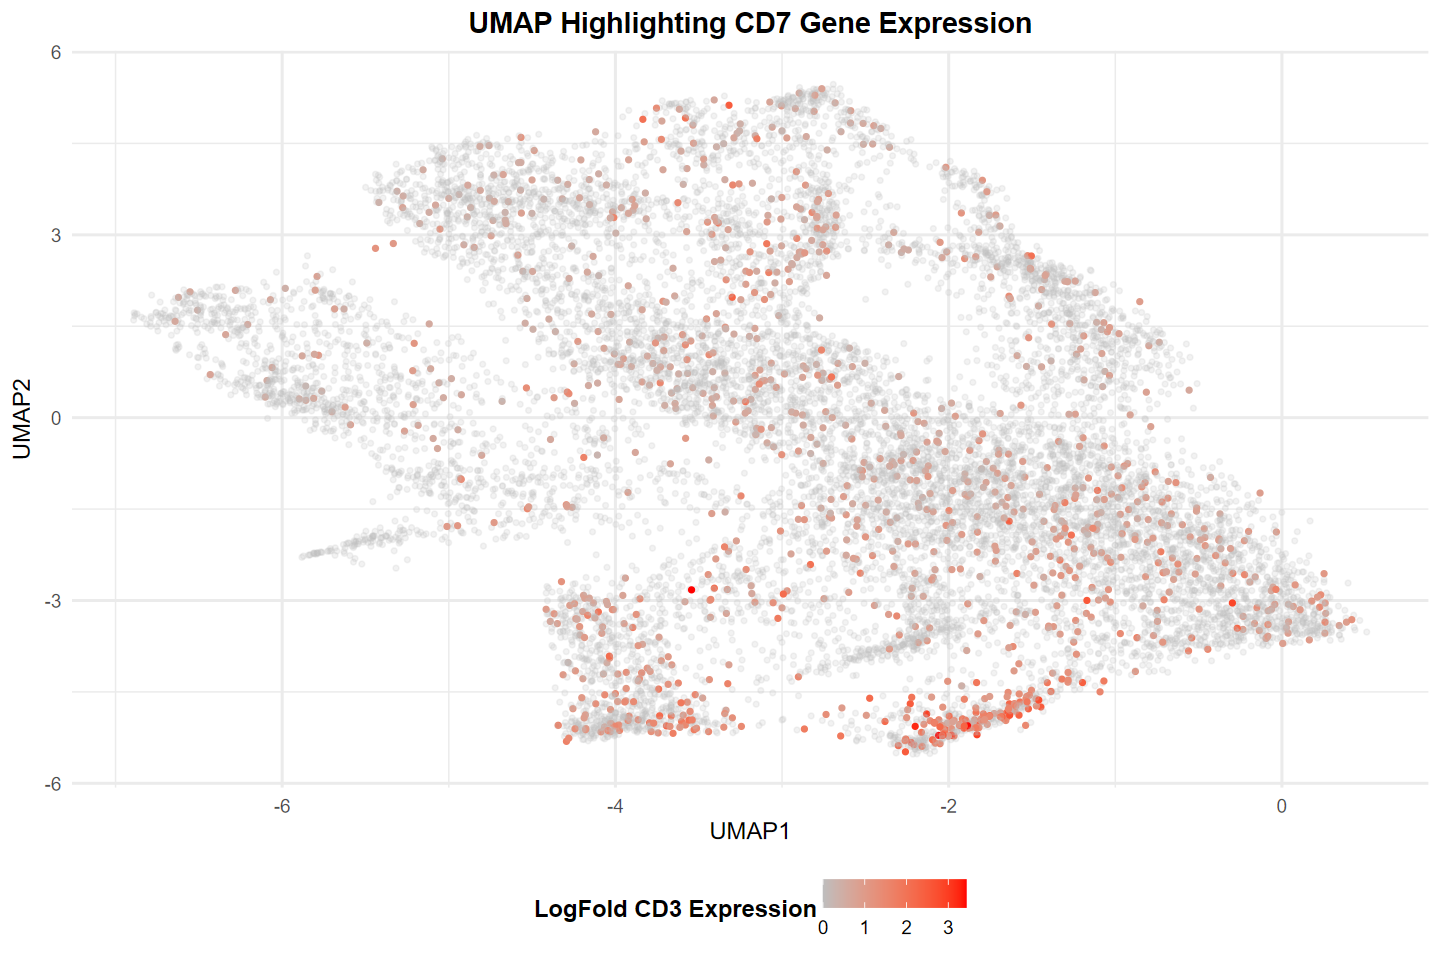

In [99]:
# Visualizing CD3 Expression across all populations and Timepoints

# Assuming "merge2" contains the logcounts assay and CD3 is the gene of interest
library(ggplot2)

# Extract CD3 gene expression values
cd3_expression <- assay(merge2, "logcounts")["CD7", ]

# Add CD3 expression to the UMAP dataframe
umap_df$CD3_expression <- cd3_expression

# Filter the UMAP dataframe to remove outliers
umap_df <- umap_df %>% filter(UMAP1 < 4)

# Create the plot
gg_umap_cd3 <- ggplot(umap_df, aes(x = UMAP1, y = UMAP2)) +
  geom_point(
    aes(color = CD3_expression),
    alpha = ifelse(umap_df$CD3_expression > 0, 1, 0.2),
    size = 1
  ) +
  scale_color_gradient(
    low = "gray",
    high = "red",
    name = "LogFold CD3 Expression"
  ) +
  labs(
    title = "UMAP Highlighting CD7 Gene Expression",
    x = "UMAP1",
    y = "UMAP2"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    legend.position = "bottom",
    legend.title = element_text(face = "bold")
  )

print(gg_umap_cd3)


In [138]:
# Establishing T cell Genes

T_genes <- c("TCF3", "RAG1", "GATA3", "TCF7", "NOTCH1", "BCL11B", "CD7")
B_genes <- c("TCF4", "PAX5", "TCF3", "RAG1", "RAG2", "BCL11A", "EBF1", "CD79A", "MEF2C")
gene_presence <- B_genes %in% rownames(merge2)
names(gene_presence) <- B_genes
gene_presence


TCF4   PAX5   TCF3   RAG1   RAG2 BCL11A   EBF1  CD79A  MEF2C 
  TRUE   TRUE   TRUE   TRUE   TRUE   TRUE   TRUE   TRUE   TRUE

In [136]:
"EBF1" %in% rownames(merge2)


[1] TRUE

In [62]:
unique(pheno.merge2)


[1] "CD34+CD45RA-CLEC12A-" "CD34-CD45RA-CLEC12A+" "CD34+CD45RA-CLEC12A+"
 [4] "CD34+CD45RA+CLEC12A-" "CD34-CD45RA+CLEC12A-" "CD34+CD45RA+CLEC12A+"
 [7] "CD34-CD45RA-CLEC12A-" "CD34-CD45RA+CLEC12A+" "CD14CD15+"           
[10] "CD10+"

In [122]:
# Check unique values in Phenotype_Group
# Check unique values in Phenotype_Group
unique(expression_df$Phenotype_Group)


[1] "Group1" "Group3" "Group2" "Other"  "Group4"

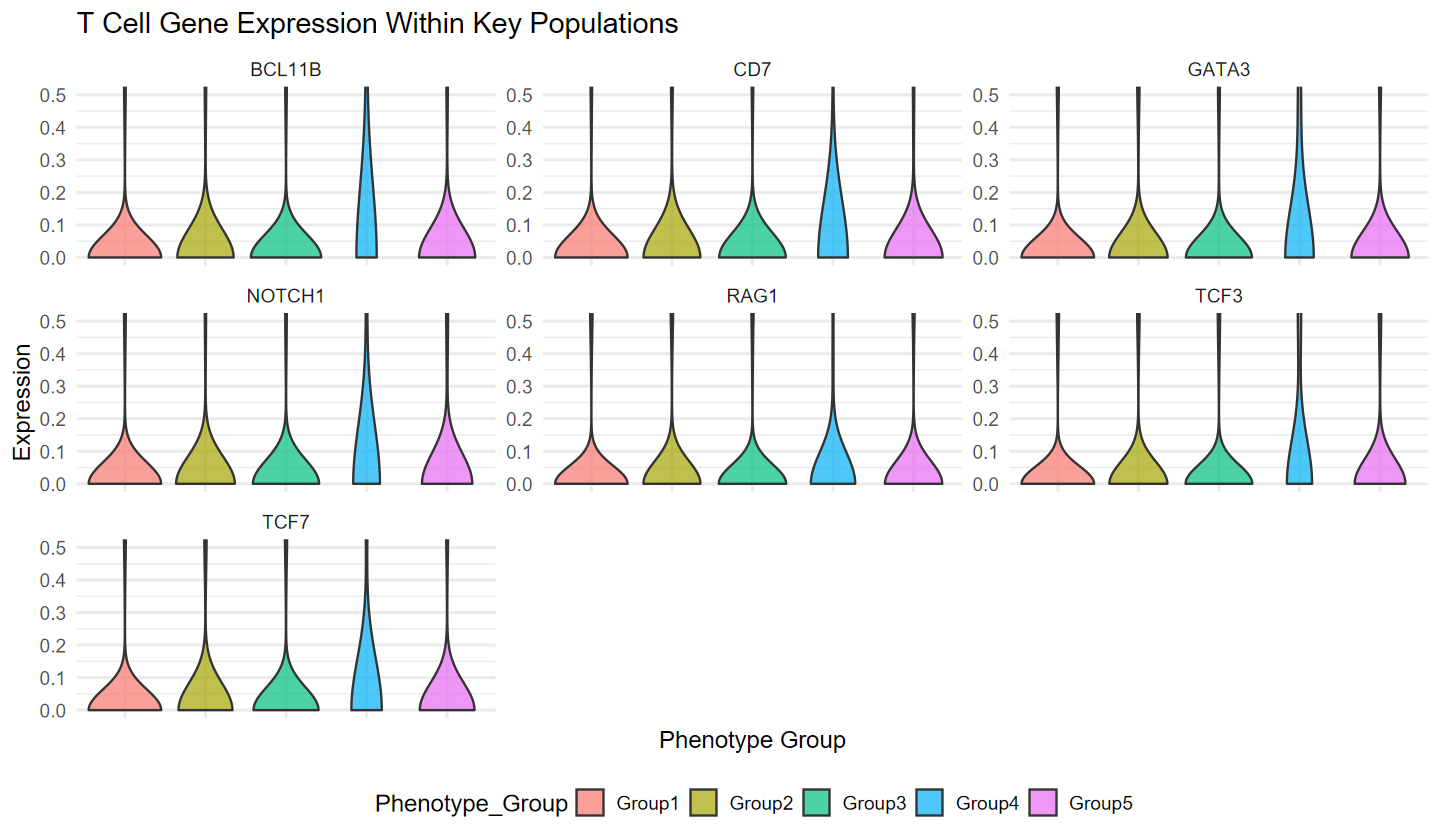

In [139]:
# T Cell Gene Expression Across Starting populations

library(ggplot2)

# Define the genes of interest
genes_of_interest <- T_genes # Replace with actual gene names

# Define the phenotypes to include in the comparison
phenotypes_of_interest <- c(
  "CD34+CD45RA-CLEC12A-", "CD34-CD45RA-CLEC12A-", "CD34+CD45RA+CLEC12A-", "CD34-CD45RA+CLEC12A-",
  "CD34-CD45RA-CLEC12A+", "CD34+CD45RA-CLEC12A+", "CD34+CD45RA+CLEC12A+", "CD34-CD45RA+CLEC12A+", "CD10+", "CD14CD15+"
) # Replace with actual phenotype names

# Extract expression data for the genes
gene_expression <- assay(merge2, "logcounts")[genes_of_interest, ]

# Combine data into a data frame
expression_df <- data.frame(
  Expression = as.vector(gene_expression),
  Gene = rep(genes_of_interest, each = ncol(gene_expression)),
  Phenotype = rep(pheno.merge2, times = length(genes_of_interest))
)

expression_df$Phenotype_Group <- sapply(expression_df$Phenotype, function(phenotype) {
  group <- names(phenotype_groups)[sapply(phenotype_groups, function(group) phenotype %in% group)]
  if (length(group) > 0) group else "Other"
})


# Example with extended plot width and group labels
library(ggplot2)

# Adjusting the plot size (for saving or interactive sessions)
options(repr.plot.width = 12) # Set a larger width for plotting

# Create the plot
ggplot(expression_df, aes(x = Phenotype_Group, y = Expression, fill = Phenotype_Group)) +
  geom_violin(trim = TRUE, alpha = 0.7) +
  facet_wrap(~Gene, scales = "free_y") +
  labs(
    title = "T Cell Gene Expression Within Key Populations",
    x = "Phenotype Group",
    y = "Expression"
  ) +
  coord_cartesian(ylim = c(0, 0.5)) + # Adjust the y-axis range to control tail length
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    legend.position = "bottom"
  )


Great! Now lets do this again with B cell genes 

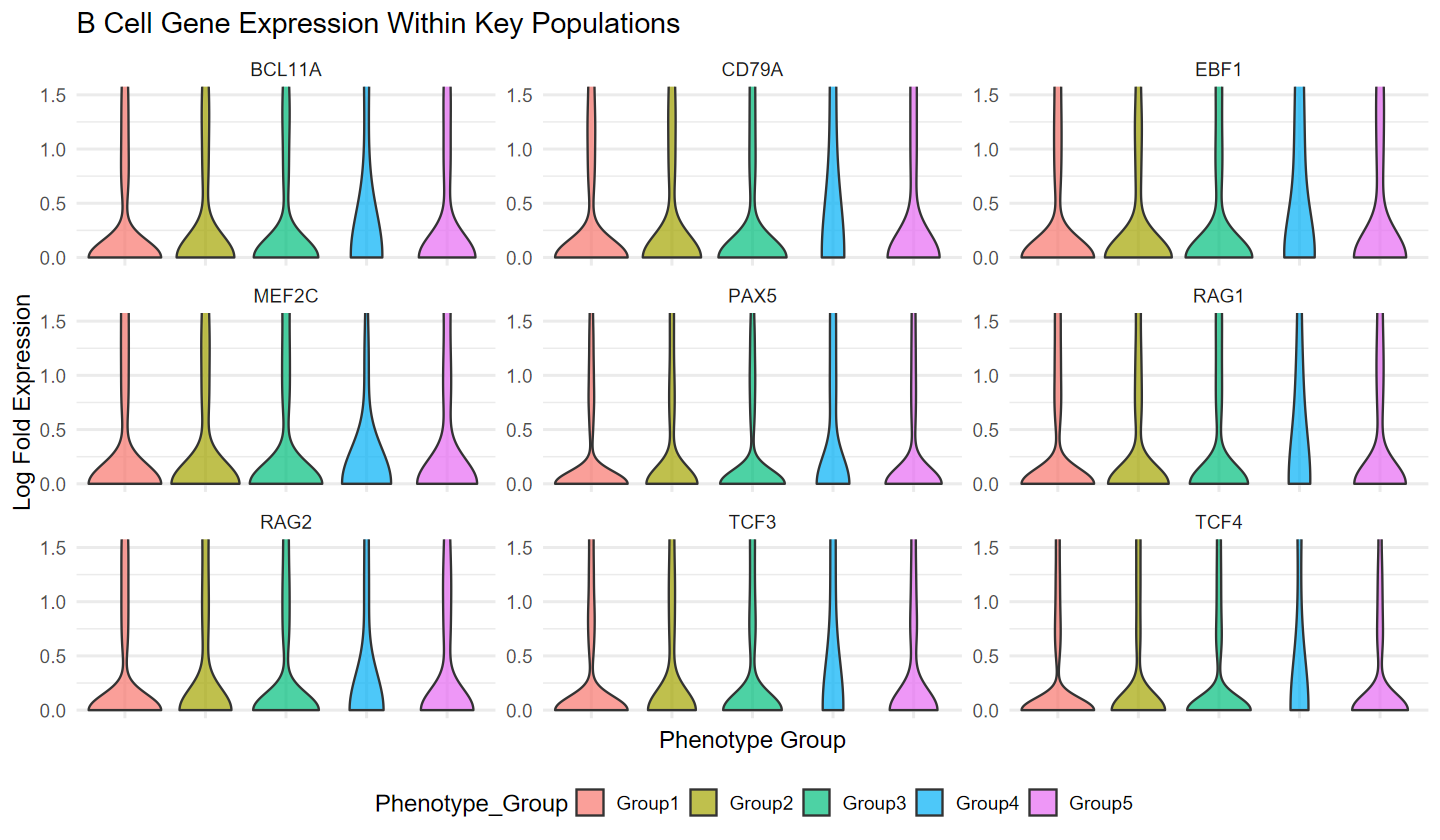

In [142]:
# B Cell Gene Expression Across Populations






library(ggplot2)

# Define the genes of interest
genes_of_interest <- B_genes # Replace with actual gene names

# Define the phenotypes to include in the comparison
phenotypes_of_interest <- c(
  "CD34+CD45RA-CLEC12A-", "CD34-CD45RA-CLEC12A-", "CD34+CD45RA+CLEC12A-", "CD34-CD45RA+CLEC12A-",
  "CD34-CD45RA-CLEC12A+", "CD34+CD45RA-CLEC12A+", "CD34+CD45RA+CLEC12A+", "CD34-CD45RA+CLEC12A+", "CD10+", "CD14CD15+"
) # Replace with actual phenotype names

# Extract expression data for the genes
gene_expression <- assay(merge2, "logcounts")[genes_of_interest, ]

# Combine data into a data frame
expression_df <- data.frame(
  Expression = as.vector(gene_expression),
  Gene = rep(genes_of_interest, each = ncol(gene_expression)),
  Phenotype = rep(pheno.merge2, times = length(genes_of_interest))
)

expression_df$Phenotype_Group <- sapply(expression_df$Phenotype, function(phenotype) {
  group <- names(phenotype_groups)[sapply(phenotype_groups, function(group) phenotype %in% group)]
  if (length(group) > 0) group else "Other"
})


# Example with extended plot width and group labels
library(ggplot2)

# Adjusting the plot size (for saving or interactive sessions)
options(repr.plot.width = 12) # Set a larger width for plotting

# Create the plot
ggplot(expression_df, aes(x = Phenotype_Group, y = Expression, fill = Phenotype_Group)) +
  geom_violin(trim = TRUE, alpha = 0.7) +
  facet_wrap(~Gene, scales = "free_y") +
  labs(
    title = "B Cell Gene Expression Within Key Populations",
    x = "Phenotype Group",
    y = "Log Fold Expression"
  ) +
  coord_cartesian(ylim = c(0, 1.5)) + # Adjust the y-axis range to control tail length
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    legend.position = "bottom"
  )


In [130]:
# Check if CD7 exists in the rownames (genes) of the SCE object
"CD7" %in% rownames(merge2) # Replace merge2 with the name of your SCE object


[1] TRUE

In [ ]:
# head(pheno.merge2)

# merge2

# index.cd10 <- which(pheno.merge2 == "CD10+")
# merge2.cd10 <- merge2[, index.cd10]

# merge2.cd10


cell1Day_7             cell2Day_7             cell3Day_7 
"CD34+CD45RA-CLEC12A-" "CD34+CD45RA-CLEC12A-" "CD34+CD45RA-CLEC12A-" 
            cell4Day_7             cell5Day_7             cell6Day_7 
"CD34+CD45RA-CLEC12A-" "CD34+CD45RA-CLEC12A-" "CD34+CD45RA-CLEC12A-"